### Imports  & Parameters

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# ugly workaround for imports
sys.path.append(os.path.split(os.getcwd())[0])
from tqdm import tqdm

import numpy as np
import scipy as sp
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as pl
import matplotlib.animation as animation
%matplotlib inline

from scipy.ndimage.interpolation import rotate

from utils.fit import *
from utils.prf import *

In [17]:
# parameters of analysis
n_pix = 40
rsq_threshold = 0.75
cv_fold=3

In [3]:
# settings that have to do with the data and experiment
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-5, 5]
stim_radius = 5.0
n_folds = 6

### Get Data

`prf_cv_fold_data` is the prf parameters, 
`rfs` are the pixel-based rf profiles.

data file found, returning local file ../data/V1.h5


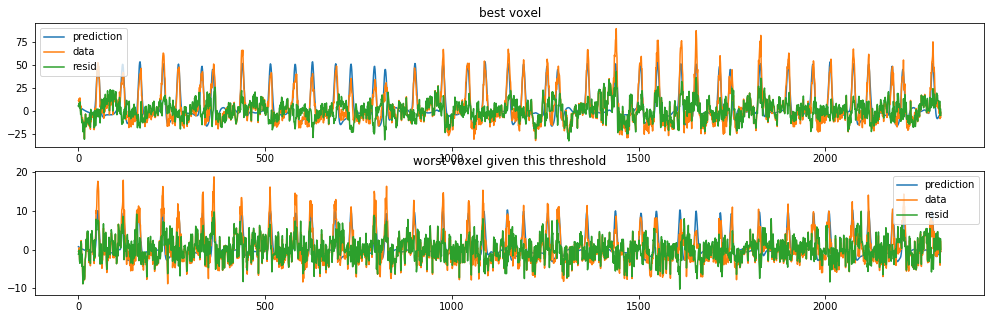

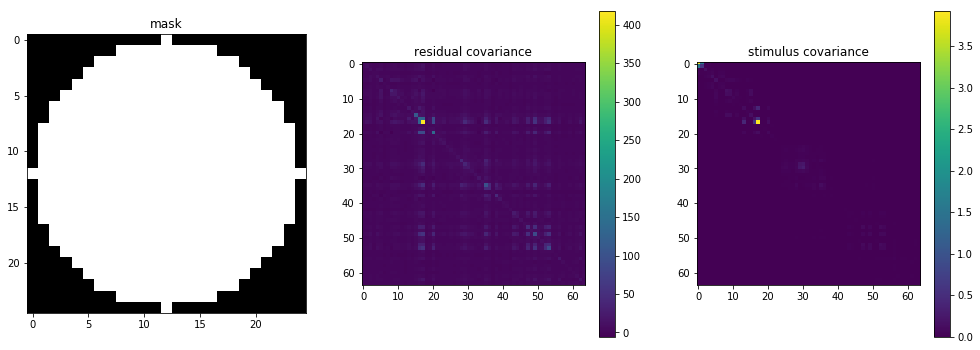

In [4]:
(prf_cv_fold_data, rfs, linear_predictor, 
 all_residuals_css, all_residual_covariance_css, 
 stimulus_covariance_WW, test_data, mask) = setup_data_from_h5(
                        data_file = '../data/V1.h5', 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=cv_fold,
                        n_folds=n_folds,
                        use_median=False)

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(mask, cmap='gray');
s.set_title('mask')
s = f.add_subplot(132)
pl.imshow(all_residual_covariance_css)
s.set_title('residual covariance')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(stimulus_covariance_WW)
s.set_title('stimulus covariance')
pl.colorbar();

max tau: 34.3374966686 min tau: 0.653421517094
sigma: -5.15066230831 rho: 0.181959344558
summed squared distance: 978613.045501


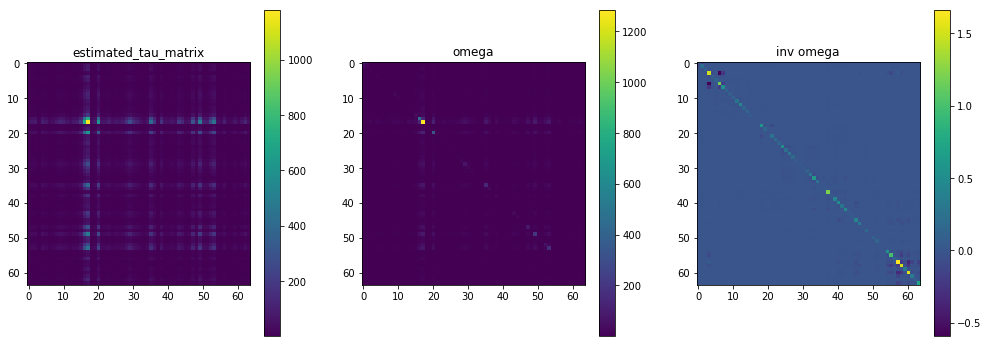

In [5]:
# estimate the covariance structure, which outputs all parameters
(estimated_tau_matrix, estimated_rho, 
 estimated_sigma, omega, 
 omega_inv, logdet) = fit_model_omega(
                                        observed_residual_covariance=all_residual_covariance_css, 
                                        featurespace_covariance=stimulus_covariance_WW,
                                        verbose=1
                                        )

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(estimated_tau_matrix)
s.set_title('estimated_tau_matrix')
pl.colorbar()
s = f.add_subplot(132)
pl.imshow(omega)
s.set_title('omega')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(omega_inv)
s.set_title('inv omega')
pl.colorbar();

In [6]:
# set up result array:
dm_pixel_logl_ratio = np.zeros((mask.sum(),test_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(test_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_Ws(
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv,
                                        linear_predictor=linear_predictor)

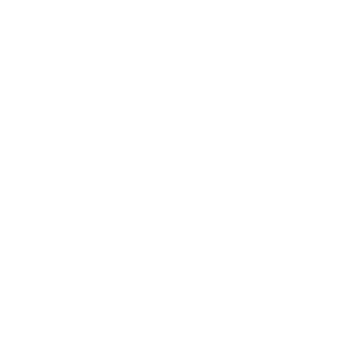

In [7]:
from IPython.display import HTML

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(dm_pixel_logl_ratio.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = dm_pixel_logl_ratio[:,t]
    im = pl.imshow(stim_2d_array/stim_2d_array.sum(), animated=True, cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)
# ani
# HTML(ani.to_html5_video())
# ani.save('out.mp4', fps=30, extra_args=['-vcodec', 'libx264'], writer=animation.FFMpegFileWriter())

In [8]:
# decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
# for t, bold in enumerate(test_data.T):
#     decoded_image[:,t] = maximize_loglikelihood(
#                                         starting_value=dm_pixel_logl_ratio[:,t],
#                                         bold=bold,
#                                         logdet=logdet,
#                                         omega_inv=omega_inv,
#                                         rfs=rfs, 
#                                         prf_data=prf_cv_fold_data)
    

In [9]:
decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
for t, bold in enumerate(tqdm(test_data.T)):
    
    starting_value=dm_pixel_logl_ratio[:,t]
    prf_data=prf_cv_fold_data
    bnds=[(-100,100) for elem in rfs]


    final_result=sp.optimize.minimize(
                                    calculate_bold_loglikelihood, 
                                    starting_value, 
                                    args=(  rfs,
                                            prf_data, 
                                            logdet, 
                                            omega_inv, 
                                            bold), 
                                    method='L-BFGS-B', 
                                    bounds=bnds,
                                    tol=1e-04,
                                    options={'disp':False})
    decoded_image[:,t] = final_result.x
    logl = -final_result.fun

100%|██████████| 462/462 [02:04<00:00,  4.02it/s]


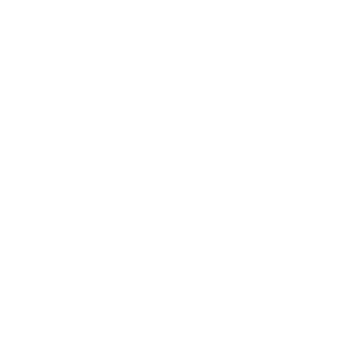

In [10]:
recon = np.zeros([decoded_image.shape[1]]+list(mask.shape) )

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(decoded_image.shape[1]):
    recon[t,mask] = decoded_image[:,t]

    im = pl.imshow(recon[t]/recon[t].sum(), animated=True, cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

# ani

In [11]:
thetas = [-1, 0, -1, 45, 270, -1,  315,  180, -1,  135,   90, -1,  225, -1]
rotated_recon = np.copy(recon).T

hrf_delay = 0
block_delimiters = np.r_[np.arange(2, 462, 34) + hrf_delay, 462]
reshrot_recon = np.zeros((8, rotated_recon.shape[0], rotated_recon.shape[1], 38))
bar_counter = 0
for i in range(len(block_delimiters) - 1):
    if thetas[i] != -1:
        rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4] = rotate(rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4],
                                                                                      axes=(
            0, 1),
            angle=thetas[i],
            reshape=False,
            mode='nearest')
        reshrot_recon[bar_counter] = rotated_recon[:, :,
                                                   block_delimiters[i]:block_delimiters[i + 1] + 4]
        bar_counter += 1

reshrot_recon_m = np.median(reshrot_recon, axis=0)

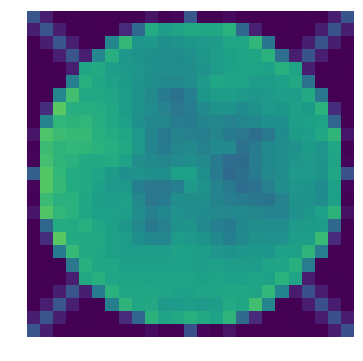

In [12]:
fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(reshrot_recon_m.shape[-1]):
    im = pl.imshow(reshrot_recon_m[...,t], animated=True, clim=[0,1], cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

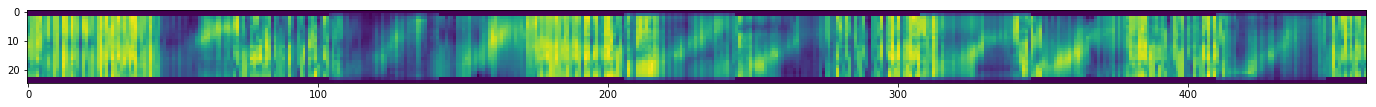

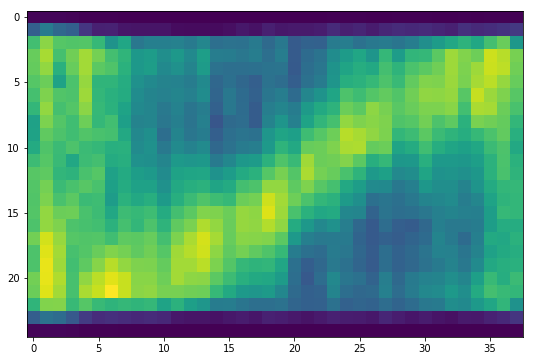

In [13]:
pl.figure(figsize=(24,7))
pl.imshow(np.median(rotated_recon, axis = 0));
pl.figure(figsize=(12,6))
pl.imshow(np.median(reshrot_recon_m, axis = 0));

### CV across folds...

  0%|          | 0/6 [00:00<?, ?it/s]

data file found, returning local file ../data/V1.h5
max tau: 26.1516342708 min tau: 0.33227391421
sigma: 23.6617351264 rho: 0.179371665804
summed squared distance: 538655.294988


 17%|█▋        | 1/6 [07:04<35:20, 424.14s/it]

data file found, returning local file ../data/V1.h5
max tau: 24.7596384768 min tau: 0.388004764822
sigma: 23.0155934384 rho: 0.185377822102
summed squared distance: 481360.331065


 33%|███▎      | 2/6 [13:15<27:13, 408.44s/it]

data file found, returning local file ../data/V1.h5
max tau: 20.2709165551 min tau: 0.527482573149
sigma: 20.4281999707 rho: 0.200565394019
summed squared distance: 301958.925929


 50%|█████     | 3/6 [19:39<20:02, 400.96s/it]

data file found, returning local file ../data/V1.h5
max tau: 15.3009042338 min tau: 0.538113512362
sigma: 14.6990570408 rho: 0.336302720745
summed squared distance: 91064.4764676


 67%|██████▋   | 4/6 [25:57<13:08, 394.16s/it]

data file found, returning local file ../data/V1.h5
max tau: 14.364873239 min tau: 0.746872823262
sigma: 18.3386987399 rho: 0.26071052212
summed squared distance: 85557.2819951


 83%|████████▎ | 5/6 [32:08<06:27, 387.16s/it]

data file found, returning local file ../data/V1.h5
max tau: 28.9486632326 min tau: -1.1547422916
sigma: 23.9353718256 rho: 0.161589219597
summed squared distance: 700258.617606


100%|██████████| 6/6 [38:45<00:00, 390.20s/it]


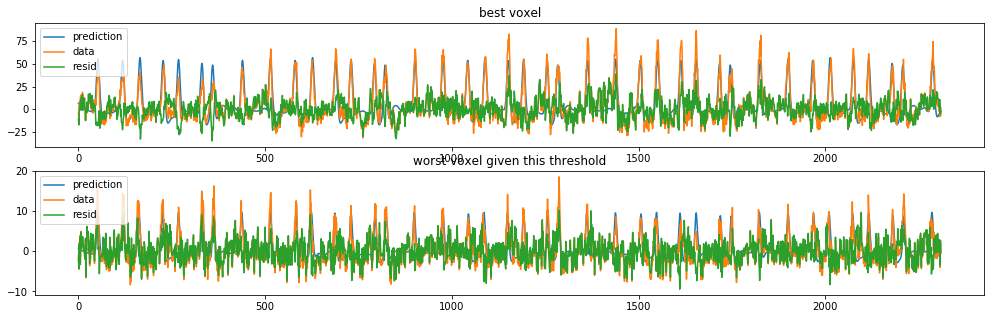

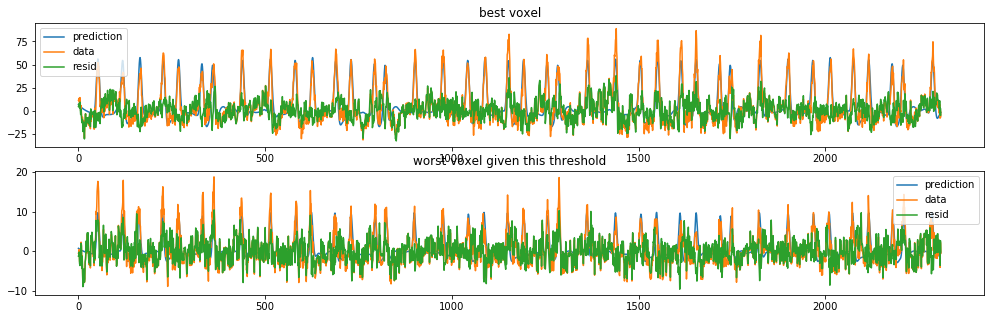

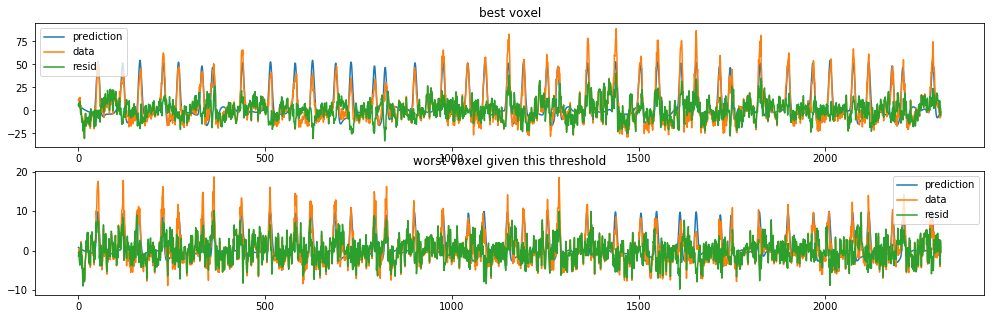

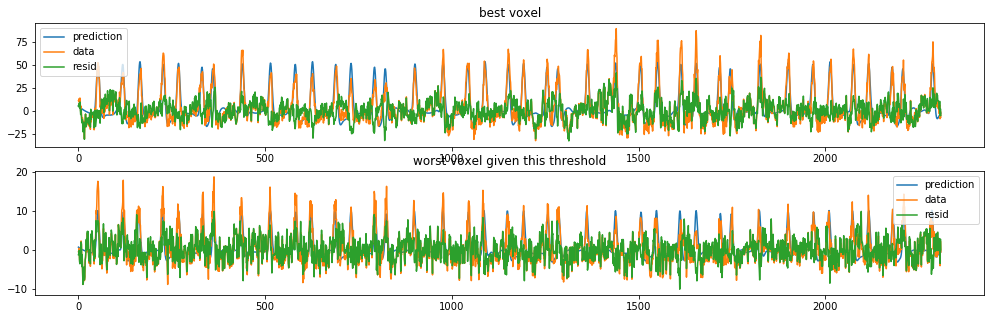

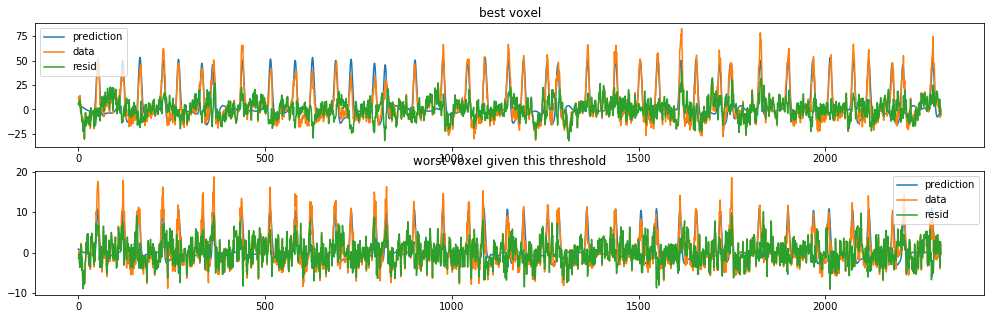

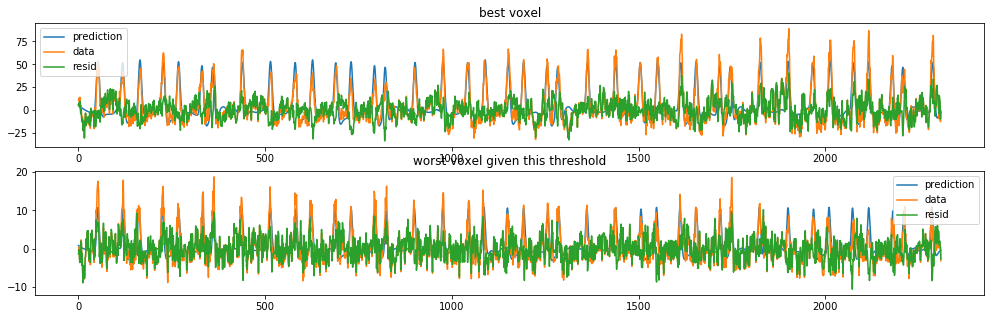

In [18]:
cv_decoded_image, cv_reshrot_recon, cv_reshrot_recon_m, \
cv_omega, cv_estimated_tau_matrix, cv_estimated_rho, \
cv_estimated_sigma = decode_cv_prfs(data_file='../data/V1.h5', 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=cv_fold,
                        n_folds=n_folds,
                        use_median=False)

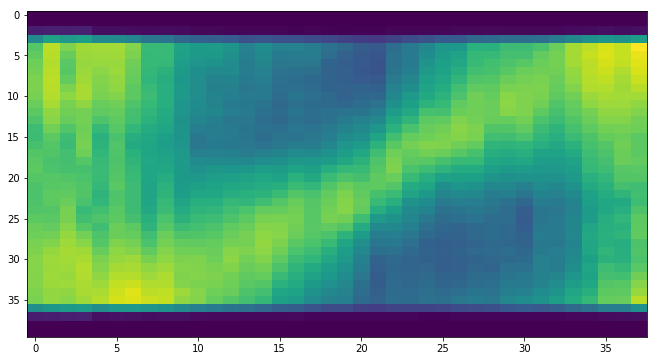

In [24]:
pl.figure(figsize=(12,6))
path = np.median(np.median(cv_reshrot_recon_m, axis=0), axis=0)
pl.imshow(path, aspect = 0.5);

In [16]:
cv_reshrot_recon_m.shape


(6, 25, 25, 38)